In [ ]:
import os
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import VarianceThreshold, SelectKBest, chi2, mutual_info_classif
from sklearn.preprocessing import MinMaxScaler
from pandas.plotting import parallel_coordinates

#os.chdir('../')
warnings.filterwarnings('ignore')


In [4]:
df = pd.read_csv('data/processed/data.csv')

In [5]:
df['Estado del egreso'] = df['Estado del egreso'].astype(float).astype(int)

In [6]:
df['Estado del egreso'].value_counts()

Estado del egreso
0    66
1    29
Name: count, dtype: int64

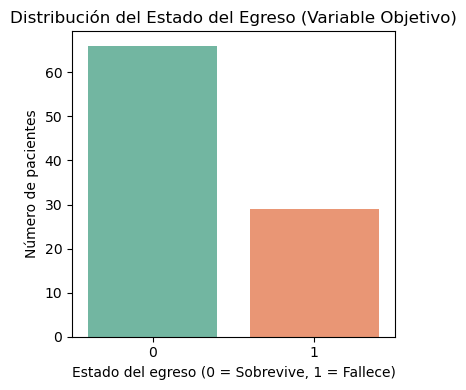

In [7]:
plt.figure(figsize=(4, 4))
sns.countplot(x='Estado del egreso', data=df, palette='Set2')
plt.title("Distribución del Estado del Egreso (Variable Objetivo)")
plt.xlabel("Estado del egreso (0 = Sobrevive, 1 = Fallece)")
plt.ylabel("Número de pacientes")
plt.tight_layout()
plt.show()

In [8]:
X_numeric = df.drop(columns=['Estado del egreso'])
scaler = MinMaxScaler()
X_normalized_df = pd.DataFrame(scaler.fit_transform(X_numeric), columns=X_numeric.columns)

In [9]:
selector_normalized = VarianceThreshold(threshold=0.0)
selector_normalized.fit(X_normalized_df)

VarianceThreshold()

In [10]:
variance_normalized_df = pd.DataFrame({
    'feature': X_normalized_df.columns,
    'var': selector_normalized.variances_
}).sort_values(by='var', ascending=False)

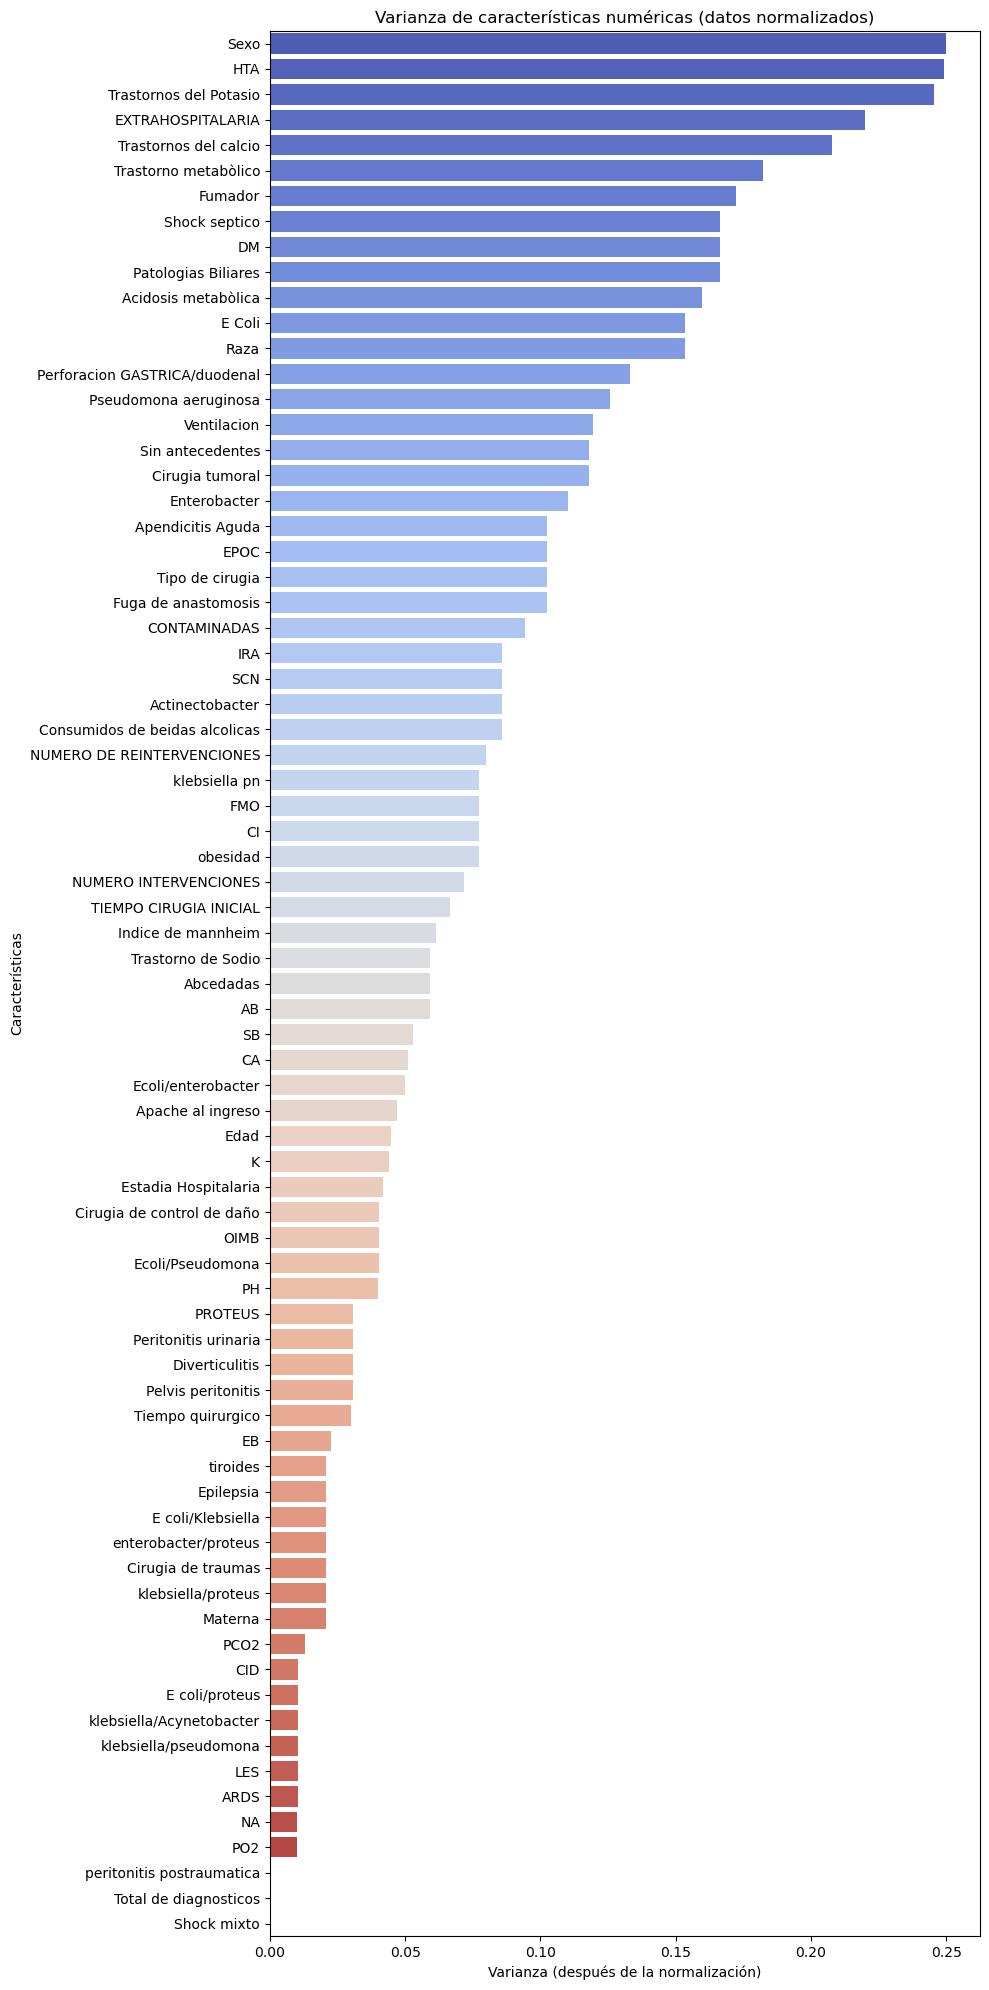

In [11]:
plt.figure(figsize=(10, 20))
sns.barplot(data=variance_normalized_df, x='var', y='feature', palette='coolwarm')
plt.title('Varianza de características numéricas (datos normalizados)')
plt.xlabel('Varianza (después de la normalización)')
plt.ylabel('Características')
plt.tight_layout()
plt.show()

In [12]:
drop_low_variance = variance_normalized_df[variance_normalized_df['var'] < 0.1]['feature'].tolist()
df_filtered = df.drop(columns=drop_low_variance)

In [13]:
matrix = df_filtered.corr()

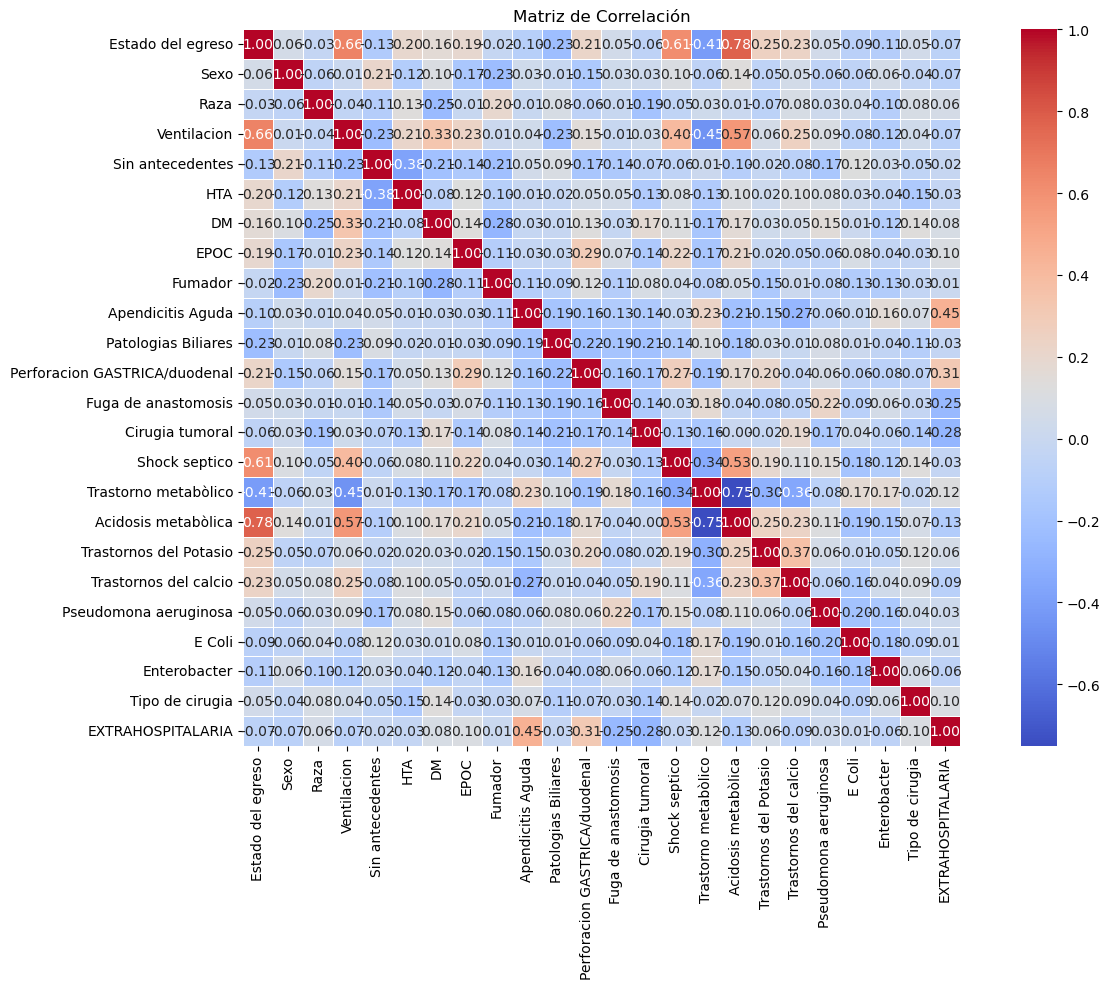

In [14]:
plt.figure(figsize=(14, 10))
sns.heatmap(matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, linewidths=0.5)
plt.title('Matriz de Correlación')
plt.tight_layout()
plt.show()

In [15]:
X, y = df_filtered.drop('Estado del egreso', axis=1), df['Estado del egreso']

### Selecci

In [16]:
selector = SelectKBest(k=5, score_func=chi2)

selector.fit_transform(X, y)

features = X.columns[selector.get_support(indices=True)]
features

Index(['Ventilacion', 'Patologias Biliares', 'Shock septico',
       'Trastorno metabòlico', 'Acidosis metabòlica'],
      dtype='object')

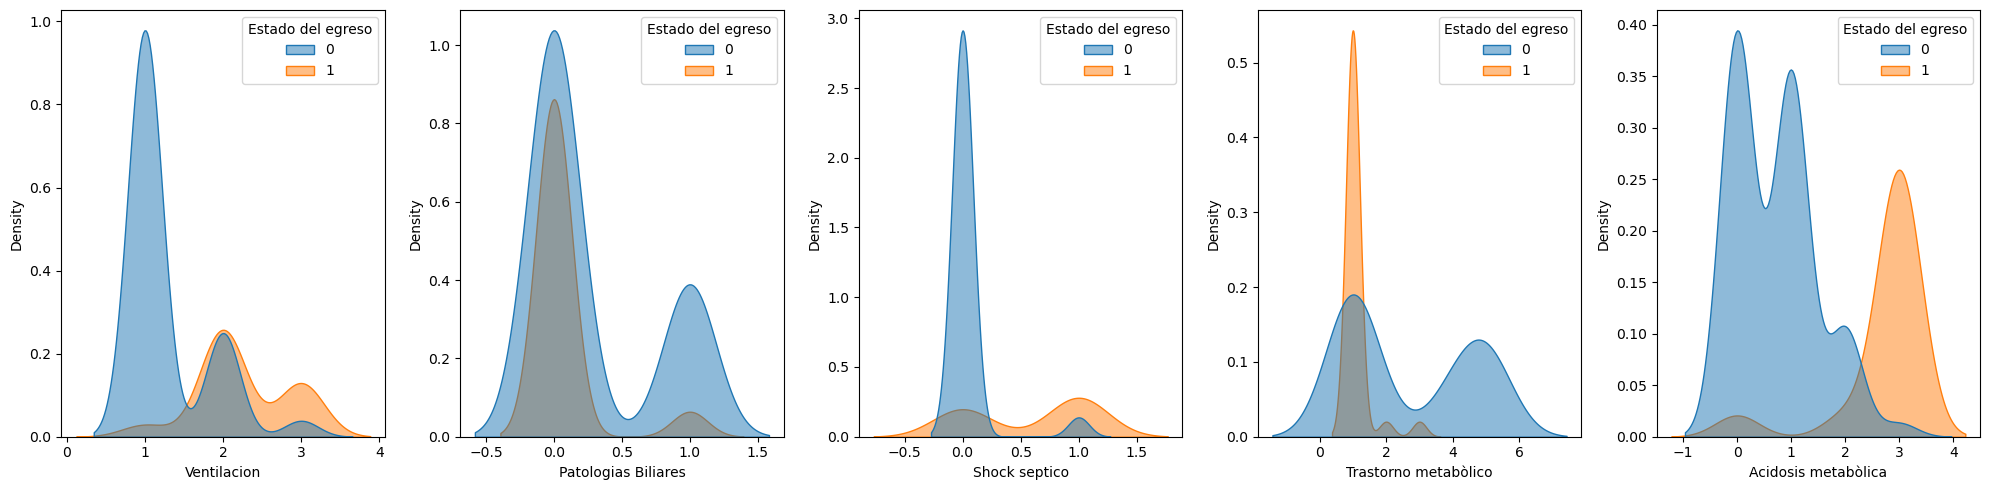

In [17]:
fig, axes = plt.subplots(1, 5, figsize=(20, 5))

for i, feature in enumerate(features):
    sns.kdeplot(x=feature, data=X, hue=y, ax=axes[i], fill=True, alpha=0.5)

plt.tight_layout()
plt.show()

- **Ventilación**: Se observa una separación entre las clases 0 y 1. Los pacientes con estado de egreso desfavorable (clase 1) tienden a tener valores más altos de ventilación. Esto sugiere que la variable posee una alta capacidad predictiva.

- **Patologías Biliares**: Ambas clases tienen distribuciones muy similares, con una gran superposición. La diferencia entre clases no es marcada; la clase 1 presenta una densidad ligeramente menor. En consecuencia, esta variable muestra una capacidad predictiva baja.

- **Shock Séptico**: La mayoría de los pacientes de clase 0 se concentran en valores cercanos a 0, mientras que la clase 1 presenta una distribución más extendida hacia valores positivos. La presencia de shock podría estar asociada a un mayor riesgo, aunque la separación entre clases no es pronunciada. Por lo tanto, se considera una variable con capacidad predictiva moderada.

- **Trastorno Metabólico**: La clase 1 presenta una densidad muy concentrada en torno a valores bajos, mientras que la clase 0 se encuentra más dispersa. Este comportamiento sugiere que el trastorno metabólico podría estar relacionado con peores resultados, especialmente en determinados rangos de valores. Se trata, por tanto, de una variable potencialmente útil desde el punto de vista predictivo.

- **Acidosis Metabólica**: La clase 1 está claramente desplazada hacia valores más altos, con poca superposición respecto a la clase 0. Los pacientes con niveles más elevados de acidosis presentan una mayor probabilidad de tener un egreso desfavorable. En consecuencia, esta variable muestra una alta capacidad predictiva.

In [18]:
features = ['Ventilacion', 'Shock septico',
       'Trastorno metabòlico', 'Acidosis metabòlica']

In [19]:
X[features].join(y).to_csv('data/pre-model/data.csv', index=False)